In [1]:
from google.colab import drive

drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [2]:
import sys
#sys.path.append("/content/drive/MyDrive/")
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/rhinoceros_hippopotamus_classification


Mounted at /content/gdrive
/content/gdrive/MyDrive/rhinoceros_hippopotamus_classification


In [3]:
!pip install torchmetrics

In [4]:
from transformers import ViTForImageClassification,ViTConfig, ViTImageProcessor
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms
from tqdm import tqdm
from torchmetrics.functional import accuracy
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split

from utils import load_dataset
%cd data

/content/gdrive/MyDrive/rhinoceros_hippopotamus_classification/data


In [5]:
save_path = Path("model.pch")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Freeze le model
for parameter in  model.parameters() :
  parameter.requires_grad = False

# Changer la derniere couche
nb_classe = 2
model.classifier = nn.Linear(model.config.hidden_size, nb_classe)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
from sklearn.model_selection import train_test_split

train_images, train_labels = load_dataset(test=False, color=False)
test_images, test_labels = load_dataset(test=True, color=False)

train_images, validation_images, train_labels, validation_labels = train_test_split(
    train_images, train_labels, shuffle=True, test_size=0.2
)

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

tensor_tr = torch.stack([transform_data(image) for image in train_images])
tensor_val = torch.stack([transform_data(image) for image in validation_images])
tensor_ts = torch.stack([transform_data(image) for image in test_images])

tensor_train = tensor_tr.expand(-1, 3, -1, -1).to(torch.float32)
tensor_validation = tensor_val.expand(-1, 3, -1, -1).to(torch.float32)
tensor_test = tensor_ts.expand(-1, 3, -1, -1).to(torch.float32)

train_tensor = TensorDataset(tensor_train, torch.tensor(train_labels, dtype=torch.long))
validation_tensor = TensorDataset(tensor_validation, torch.tensor(validation_labels, dtype=torch.long))
test_tensor = TensorDataset(tensor_test, torch.tensor(test_labels, dtype=torch.long))

BATCH_SIZE = 64

Train = DataLoader(train_tensor, shuffle=True, batch_size=BATCH_SIZE)
Validation = DataLoader(validation_tensor, shuffle=False, batch_size=BATCH_SIZE)
Test = DataLoader(test_tensor, shuffle=False, batch_size=BATCH_SIZE)


In [7]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')

In [8]:
num_epochs = 10
model = model.to(device)
accuracy_train = []
loss_train = []

accuracy_validation = []
loss_validation = []

for epoch in range(num_epochs):
  acc_accuracy_train = 0
  acc_accuracy_test = 0
  acc_loss_train = 0
  acc_loss_test = 0
  data_train_tqdm = tqdm(Train,desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False, dynamic_ncols=True)

  for data,label in data_train_tqdm:
      # Forward pass
      data = data.to(device)
      label = label.to(device)
      outputs = model(data)
      prediction = outputs.logits
      predict_final = torch.argmax(prediction, axis = 1)
      acc_accuracy_train += accuracy(predict_final,label, task = "BINARY")
      loss_ = loss(prediction, label)
      acc_loss_train += loss_.item()
      optimizer.zero_grad()
      loss_.backward()
      optimizer.step()

  if epoch +1 == num_epochs :
    with save_path.open('wb') as fp :
      torch.save(model,fp)

  acc = (acc_accuracy_train / len(Train))
  accuracy_train.append(acc)
  loss_train.append(acc_loss_train)


  with torch.no_grad() :
    for data_val,label_test in Validation :
      data_val = data_val.to(device)
      label_test = label_test.to(device)
      output = model(data_val)
      prediction = output.logits
      acc_loss_test += loss(prediction,label_test).item()
      acc_accuracy_test += accuracy(torch.argmax(prediction,axis = 1),label_test,task = "BINARY")

  accuracy_validation.append(acc_accuracy_test/len(Validation))
  loss_validation.append(acc_loss_test)

In [9]:
list_acc_train = [acc.item() for acc in accuracy_train]
list_acc_val = [acc.item() for acc in accuracy_validation]

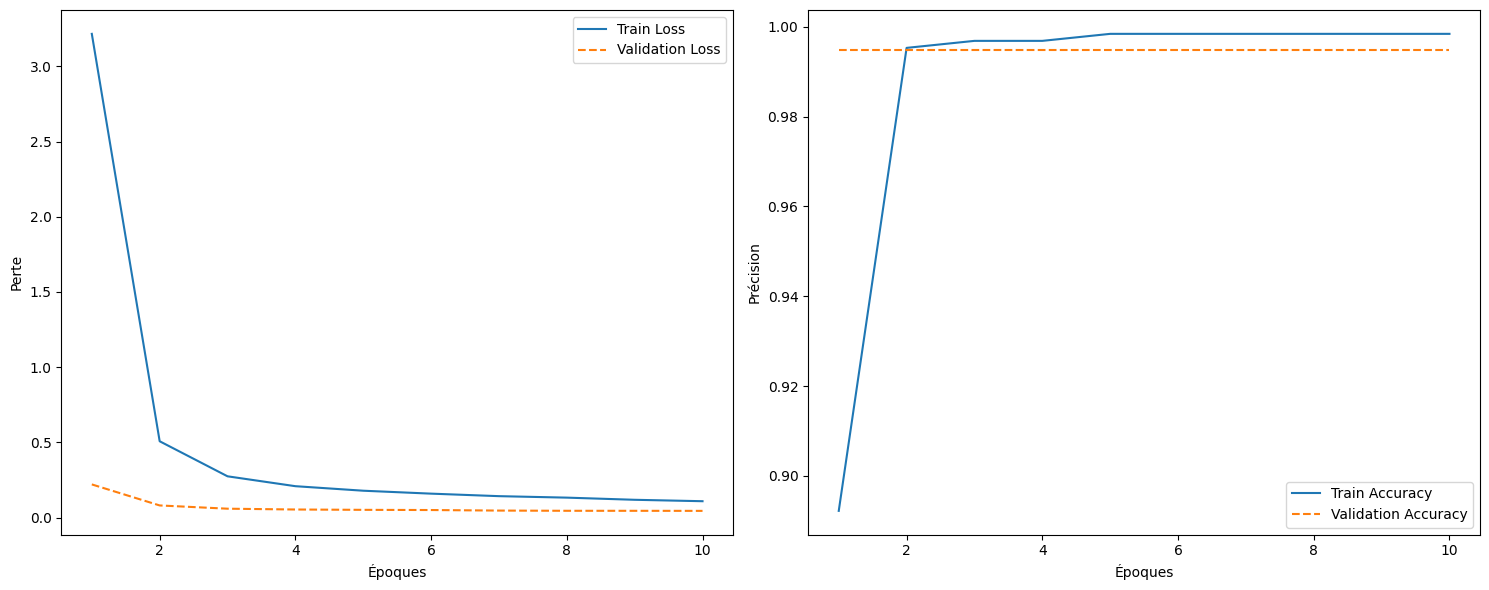

In [17]:
epochs = range(1,num_epochs+1)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)  # 2 rows, 1 column, this is the first subplot
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_validation, label='Validation Loss', linestyle='--')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)  # 2 rows, 1 column, this is the second subplot
plt.plot(epochs, list_acc_train, label='Train Accuracy')
plt.plot(epochs, list_acc_val, label='Validation Accuracy', linestyle='--')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Subplot for Loss

plt.tight_layout()
plt.savefig('Loss_Acc_VIT_No_Color.png')
plt.show()

In [11]:
tensor_test = tensor_test.to(device)
prediction = torch.argmax(model(tensor_test).logits,dim = 1)
accuracy_test = accuracy(prediction,torch.tensor(test_labels, dtype=torch.long,device = device),task = "BINARY")
print('l accuracy de test est de :', accuracy_test.item())

l accuracy de test est de : 1.0
